In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

%matplotlib inline

# Creating CSV
import glob
import csv

# Display Graph
from IPython.display import clear_output, Image, display, HTML

# Helpers
from ocr.helpers import implt
from ocr.mlhelpers import TrainingPlot, DataSet

print("OpenCV: " + cv2.__version__)
print("Numpy: " + np.__version__)
print("TensorFlow: " + tf.__version__)

OpenCV: 3.1.0
Numpy: 1.12.1
TensorFlow: 1.1.0-rc2


In [2]:
def sofmaxLabels(lab, clas):
    """ Transform labels for sofmax classification """
    newLab = np.zeros((len(lab), clas), dtype=np.int8)
    for i in range(len(lab)):
        newLab[i][int(lab[i][0])] = 1
    return newLab

### Global Variables

In [3]:
LANG = 'en'

### Load Images

In [4]:
EN_CLAS = 53
CZ_CLAS = 83
CLAS = 53

if LANG == 'en':
    CLAS = EN_CLAS
elif LANG == 'cz':
    CLAS = CZ_CLAS

# Dimension 64x64 = 4096
n_pixels = 64*64
# Load data from csv
images = np.genfromtxt('data/charclas/' + LANG + '-data.csv', delimiter=',')
labels = np.genfromtxt('data/charclas/' + LANG + '-labels.csv', delimiter=',')
labels = np.reshape(labels, (len(labels), 1))

# Regularization of images
images[images < 40] = 0
images = images.astype(np.float32)
images = np.multiply(images , 1.0 / 255.0)

# Transform labels for sofmax output
llabels = sofmaxLabels(labels, CLAS)

# Prepare training dataset
trainSet = DataSet(images[10:], llabels[10:])
# Test images
testImages = images[:10]

print("CSV data files loaded.")
print("Number of images: " + str(len(images)))

CSV data files loaded.
Number of images: 2607


### Graph

In [5]:
# Layers creating help functions
def weight_variable(shape, name):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1), name=name)

def bias_variable(shape, name):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1), name=name)

# Fully connceted
def FC_layer(X, W, b):
    return tf.matmul(X, W) + b

In [6]:
# Input placeholder
x = tf.placeholder(tf.float32, [None, 4096], name="x")


### ENCODER ###
latent_dim = 20
#num neurons
h_dim = 500

# Layer 1
W_enc = weight_variable([n_pixels, h_dim], 'W_enc')
b_enc = bias_variable([h_dim], 'b_enc')
h_enc = tf.nn.tanh(FC_layer(x, W_enc, b_enc))

# Layer 2
W_mu = weight_variable([h_dim, latent_dim], 'W_mu')
b_mu = bias_variable([latent_dim], 'b_mu')
mu = FC_layer(h_enc, W_mu, b_mu) #mean

# Reparamterization
W_logstd = weight_variable([h_dim, latent_dim], 'W_logstd')
b_logstd = bias_variable([latent_dim], 'b_logstd')
logstd = FC_layer(h_enc, W_logstd, b_logstd)

# Reparameterization
noise = tf.random_normal([1, latent_dim])
z = tf.multiply(noise, tf.exp(.5*logstd)) + mu

### DECODER ###
# Layer 1
W_dec = weight_variable([latent_dim, h_dim], 'W_dec')
b_dec = bias_variable([h_dim], 'b_dec')
# Pass in z
h_dec = tf.nn.tanh(FC_layer(z, W_dec, b_dec))

# Layer 2
W_reconstruct = weight_variable([h_dim, n_pixels], 'W_reconstruct')
b_reconstruct = bias_variable([n_pixels], 'b_reconstruct')
# Output back to 0 - 1 --> Sigmoid
reconstruction = tf.nn.sigmoid(FC_layer(h_dec, W_reconstruct, b_reconstruct))

In [7]:
### Loss Function ###
# variational lower bound
log_likelihood = tf.reduce_sum(x*tf.log(reconstruction + 1e-9)+(1 - x)*tf.log(1 - reconstruction + 1e-9), reduction_indices=1)

#KL Divergence
KL_term = -.5*tf.reduce_sum(1 + 2*logstd - tf.pow(mu,2) - tf.exp(2*logstd), reduction_indices=1)

# This allows us to use stochastic gradient descent with respect to the variational parameters
variational_lower_bound = -tf.reduce_mean(log_likelihood - KL_term)
optimizer = tf.train.AdadeltaOptimizer().minimize(variational_lower_bound)

### Training

In [8]:
# Init all variables and start the session!
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)
# Add ops to save and restore all the variables.
saver = tf.train.Saver()

### SETTINGS  ###
TRAIN_STEPS = 500000
RECORD_ITER = 10000
BATCH_SIZE = 200

# Store values for ploting
variational_lower_bound_array = []
log_likelihood_array = []
KL_term_array = []
iteration_array = [i*RECORD_ITER for i in range(int(TRAIN_STEPS/RECORD_ITER))]


for i in range(TRAIN_STEPS):
    # Get Batch
    x_batch, _ = trainSet.next_batch(BATCH_SIZE)
    # Run Optimizer
    optimizer.run(feed_dict={x: x_batch})

    if i%RECORD_ITER == 0:       
        vlb_eval = variational_lower_bound.eval(feed_dict={x: x_batch})
        
        variational_lower_bound_array.append(vlb_eval)
        log_likelihood_array.append(np.mean(log_likelihood.eval(feed_dict={x: x_batch})))
        KL_term_array.append(np.mean(KL_term.eval(feed_dict={x: x_batch})))
        
        saver.save(sess, 'models/img-gener/' + LANG + '/ImgGen')
        
        print("Iteration: {}, Loss: {}".format(i, vlb_eval))
        
# Final Save
saver.save(sess, 'models/img-gener/' + LANG + '/ImgGen')

Iteration: 0, Loss: 3856.904296875
Iteration: 10000, Loss: 2213.38525390625
Iteration: 20000, Loss: 1449.484375
Iteration: 30000, Loss: 1341.4471435546875
Iteration: 40000, Loss: 1247.160888671875
Iteration: 50000, Loss: 1185.2548828125
Iteration: 60000, Loss: 1206.12255859375
Iteration: 70000, Loss: 1171.7012939453125
Iteration: 80000, Loss: 1160.2322998046875
Iteration: 90000, Loss: 1116.689208984375
Iteration: 100000, Loss: 1124.3192138671875
Iteration: 110000, Loss: 1072.2064208984375
Iteration: 120000, Loss: 1031.6903076171875
Iteration: 130000, Loss: 1058.323486328125
Iteration: 140000, Loss: 1068.42626953125
Iteration: 150000, Loss: 1043.7645263671875
Iteration: 160000, Loss: 1036.17578125
Iteration: 170000, Loss: 1006.1585693359375
Iteration: 180000, Loss: 986.4295043945312
Iteration: 190000, Loss: 979.6051635742188
Iteration: 200000, Loss: 966.9588012695312
Iteration: 210000, Loss: 981.9550170898438
Iteration: 220000, Loss: 979.7481079101562
Iteration: 230000, Loss: 934.045288

'models/img-gener/en/ImgGen'

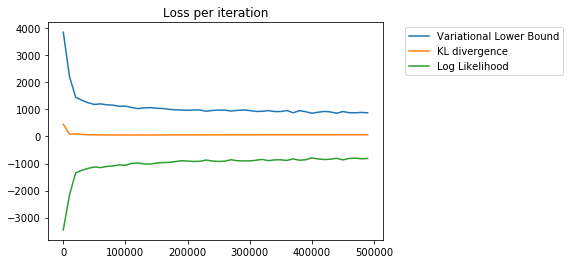

In [9]:
plt.figure()
#plot these 3 terms
plt.plot(iteration_array, variational_lower_bound_array)
plt.plot(iteration_array, KL_term_array)
plt.plot(iteration_array, log_likelihood_array)
plt.legend(['Variational Lower Bound', 'KL divergence', 'Log Likelihood'], bbox_to_anchor=(1.05, 1), loc=2)
plt.title('Loss per iteration')
plt.show()

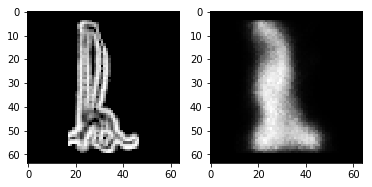

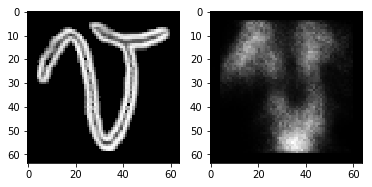

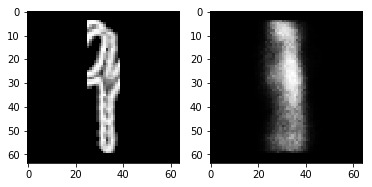

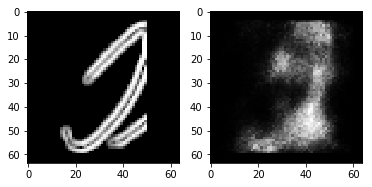

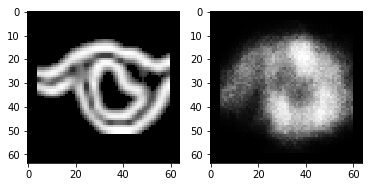

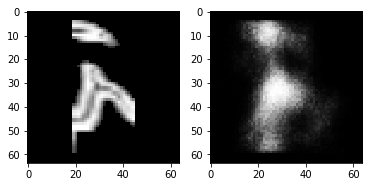

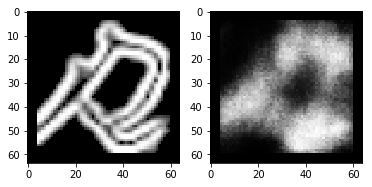

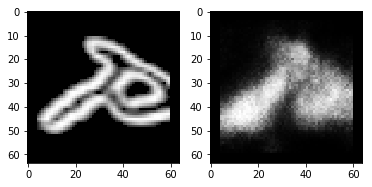

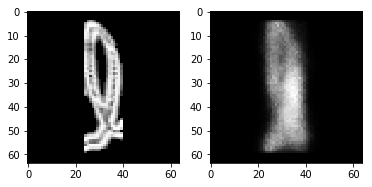

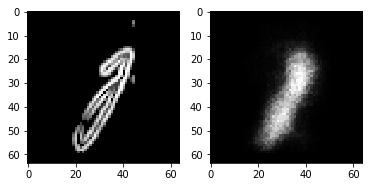

In [16]:
load_model = False
if load_model:
    import os
    saver.restore(sess, 'models/img-gener/' + LANG + '/ImgGen')

num_pairs = 10
for i in range(num_pairs):
    # Reshaping to show original test image
    x_image = np.reshape(testImages[i], (64,64))
    
    plt.figure()
    plt.subplot(121)
    plt.imshow(x_image, cmap='gray')
    #reconstructed image, feed the test image to the decoder
    x_reconstruction = reconstruction.eval(feed_dict={x: np.reshape(x_image, (1, n_pixels))})
    
    x_reconstruction_image = np.reshape(x_reconstruction, (64,64))
    plt.subplot(122)
    plt.imshow(x_reconstruction_image, cmap='gray')
    plt.show()